
<a id='writing-good-code'></a>
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Writing Good Code


<a id='index-0'></a>

## Contents

- [Writing Good Code](#Writing-Good-Code)  
  - [Overview](#Overview)  
  - [An Example of Poor Code](#An-Example-of-Poor-Code)  
  - [Good Coding Practice](#Good-Coding-Practice)  
  - [Revisiting the Example](#Revisiting-the-Example)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

## Overview

When computer programs are small, poorly written code is not overly costly.

But more data, more sophisticated models, and more computer power are enabling us to take on more challenging problems that involve writing longer programs.

For such programs, investment in good coding practices will pay high returns.

The main payoffs are higher productivity and faster code.

In this lecture, we review some elements of good coding practice.

We also touch on modern developments in scientific computing — such as just in time compilation — and how they affect good program design.

## An Example of Poor Code

Let’s have a look at some poorly written code.

The job of the code is to generate and plot time series of the simplified Solow model


<a id='equation-gc-solmod'></a>
$$
k_{t+1} = s k_t^{\alpha} + (1 - \delta) k_t,
\quad t = 0, 1, 2, \ldots \tag{1}
$$

Here

- $ k_t $ is capital at time $ t $ and  
- $ s, \alpha, \delta $ are parameters (savings, a productivity parameter and depreciation)  


For each parameterization, the code

1. sets $ k_0 = 1 $  
1. iterates using [(1)](#equation-gc-solmod) to produce a sequence $ k_0, k_1, k_2 \ldots , k_T $  
1. plots the sequence  


The plots will be grouped into three subfigures.

In each subfigure, two parameters are held fixed while another varies

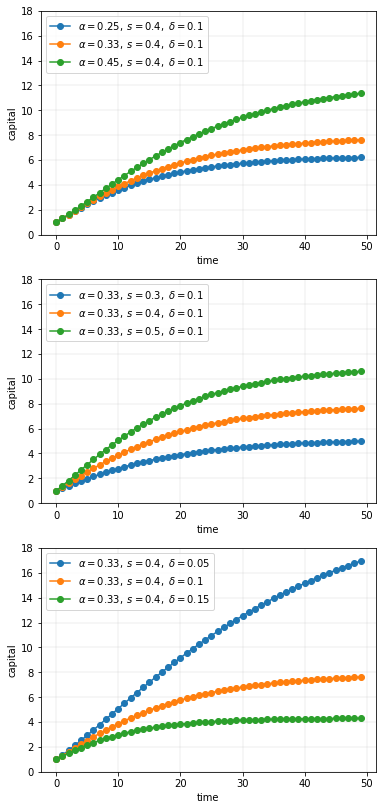

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Allocate memory for time series
k = np.empty(50)

fig, axes = plt.subplots(3, 1, figsize=(6, 14))

# Trajectories with different α
δ = 0.1
s = 0.4
α = (0.25, 0.33, 0.45)

for j in range(3):
    k[0] = 1
    for t in range(49):
        k[t+1] = s * k[t]**α[j] + (1 - δ) * k[t]
    axes[0].plot(k, 'o-', label=rf"$\alpha = {α[j]},\; s = {s},\; \delta={δ}$")

axes[0].grid(lw=0.2)
axes[0].set_ylim(0, 18)
axes[0].set_xlabel('time')
axes[0].set_ylabel('capital')
axes[0].legend(loc='upper left', frameon=True)

# Trajectories with different s
δ = 0.1
α = 0.33
s = (0.3, 0.4, 0.5)

for j in range(3):
    k[0] = 1
    for t in range(49):
        k[t+1] = s[j] * k[t]**α + (1 - δ) * k[t]
    axes[1].plot(k, 'o-', label=rf"$\alpha = {α},\; s = {s[j]},\; \delta={δ}$")

axes[1].grid(lw=0.2)
axes[1].set_xlabel('time')
axes[1].set_ylabel('capital')
axes[1].set_ylim(0, 18)
axes[1].legend(loc='upper left', frameon=True)

# Trajectories with different δ
δ = (0.05, 0.1, 0.15)
α = 0.33
s = 0.4

for j in range(3):
    k[0] = 1
    for t in range(49):
        k[t+1] = s * k[t]**α + (1 - δ[j]) * k[t]
    axes[2].plot(k, 'o-', label=rf"$\alpha = {α},\; s = {s},\; \delta={δ[j]}$")

axes[2].set_ylim(0, 18)
axes[2].set_xlabel('time')
axes[2].set_ylabel('capital')
axes[2].grid(lw=0.2)
axes[2].legend(loc='upper left', frameon=True)

plt.show()

True, the code more or less follows [PEP8](https://www.python.org/dev/peps/pep-0008/).

At the same time, it’s very poorly structured.

Let’s talk about why that’s the case, and what we can do about it.

## Good Coding Practice

There are usually many different ways to write a program that accomplishes a given task.

For small programs, like the one above, the way you write code doesn’t matter too much.

But if you are ambitious and want to produce useful things, you’ll  write medium to large programs too.

In those settings, coding style matters **a great deal**.

Fortunately, lots of smart people have thought about the best way to write code.

Here are some basic precepts.

### Don’t Use Magic Numbers

If you look at the code above, you’ll see numbers like 50 and 49 and 3 scattered through the code.

These kinds of numeric literals in the body of your code are sometimes called “magic numbers”.

This is not a compliment.

While numeric literals are not all evil, the numbers shown in the program above
should certainly be replaced by named constants.

For example, the code above could declare the variable time_series_length = 50.

Then in the loops, 49 should be replaced by time_series_length - 1.

The advantages are:

- the meaning is much clearer throughout  
- to alter the time series length, you only need to change one value  

### Don’t Repeat Yourself

The other mortal sin in the code snippet above is repetition.

Blocks of logic (such as the loop to generate time series) are repeated with only minor changes.

This violates a fundamental tenet of programming: Don’t repeat yourself (DRY).

- Also called DIE (duplication is evil).  


Yes, we realize that you can just cut and paste and change a few symbols.

But as a programmer, your aim should be to **automate** repetition, **not** do it yourself.

More importantly, repeating the same logic in different places means that eventually one of them will likely be wrong.

If you want to know more, read the excellent summary found on [this page](https://code.tutsplus.com/tutorials/3-key-software-principles-you-must-understand--net-25161).

We’ll talk about how to avoid repetition below.

### Minimize Global Variables

Sure, global variables (i.e., names assigned to values outside of any function or class) are convenient.

Rookie programmers typically use global variables with abandon — as we once did ourselves.

But global variables are dangerous, especially in medium to large size programs, since

- they can affect what happens in any part of your program  
- they can be changed by any function  


This makes it much harder to be certain about what some  small part of a given piece of code actually commands.

Here’s a [useful discussion on the topic](http://wiki.c2.com/?GlobalVariablesAreBad).

While the odd global in small scripts is no big deal, we recommend that you teach yourself to avoid them.

(We’ll discuss how just below).

#### JIT Compilation

For scientific computing, there is another good reason to avoid global variables.

As [we’ve seen in previous lectures](numba.ipynb), JIT compilation can generate excellent performance for scripting languages like Python.

But the task of the compiler used for JIT compilation becomes harder when global variables are present.

Put differently, the type inference required for JIT compilation is safer and
more effective when variables are sandboxed inside a function.

### Use Functions or Classes

Fortunately, we can easily avoid the evils of global variables and WET code.

- WET stands for “we enjoy typing” and is the opposite of DRY.  


We can do this by making frequent use of functions or classes.

In fact, functions and classes are designed specifically to help us avoid shaming ourselves by repeating code or excessive use of global variables.

#### Which One, Functions or Classes?

Both can be useful, and in fact they work well with each other.

We’ll learn more about these topics over time.

(Personal preference is part of the story too)

What’s really important is that you use one or the other or both.

## Revisiting the Example

Here’s some code that reproduces the plot above with better coding style.

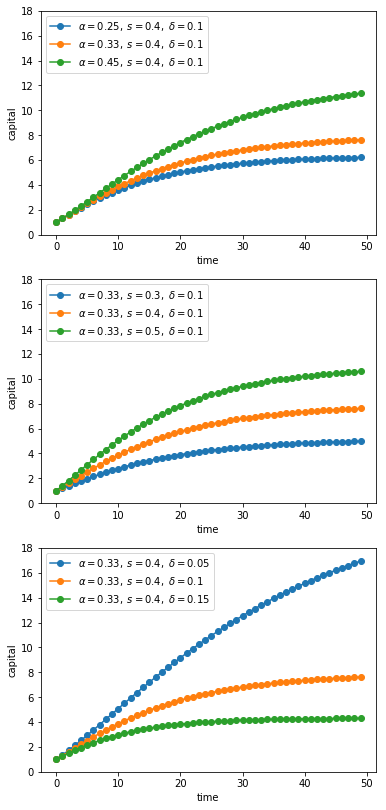

In [2]:
from itertools import product

def plot_path(ax, αs, s_vals, δs, series_length=50):
    """
    Add a time series plot to the axes ax for all given parameters.
    """
    k = np.empty(series_length)

    for (α, s, δ) in product(αs, s_vals, δs):
        k[0] = 1
        for t in range(series_length-1):
            k[t+1] = s * k[t]**α + (1 - δ) * k[t]
        ax.plot(k, 'o-', label=rf"$\alpha = {α},\; s = {s},\; \delta = {δ}$")

    ax.set_xlabel('time')
    ax.set_ylabel('capital')
    ax.set_ylim(0, 18)
    ax.legend(loc='upper left', frameon=True)

fig, axes = plt.subplots(3, 1, figsize=(6, 14))

# Parameters (αs, s_vals, δs)
set_one = ([0.25, 0.33, 0.45], [0.4], [0.1])
set_two = ([0.33], [0.3, 0.4, 0.5], [0.1])
set_three = ([0.33], [0.4], [0.05, 0.1, 0.15])

for (ax, params) in zip(axes, (set_one, set_two, set_three)):
    αs, s_vals, δs = params
    plot_path(ax, αs, s_vals, δs)

plt.show()

If you inspect this code, you will see that

- it uses a function to avoid repetition.  
- Global variables are quarantined by collecting them together at the end, not the start of the program.  
- Magic numbers are avoided.  
- The loop at the end where the actual work is done is short and relatively simple.  

## Exercises

### Exercise 1

Here is some code that needs improving.

It involves a basic supply and demand problem.

Supply is given by

$$
q_s(p) = \exp(\alpha p) - \beta.
$$

The demand curve is

$$
q_d(p) = \gamma p^{-\delta}.
$$

The values $ \alpha $, $ \beta $, $ \gamma $ and
$ \delta $ are **parameters**

The equilibrium $ p^* $ is the price such that
$ q_d(p) = q_s(p) $.

We can solve for this equilibrium using a root finding algorithm.
Specifically, we will find the $ p $ such that $ h(p) = 0 $,
where

$$
h(p) := q_d(p) - q_s(p)
$$

This yields the equilibrium price $ p^* $. From this we get the
equilibrium price by $ q^* = q_s(p^*) $

The parameter values will be

- $ \alpha = 0.1 $  
- $ \beta = 1 $  
- $ \gamma = 1 $  
- $ \delta = 1 $  

In [3]:
from scipy.optimize import brentq

# Compute equilibrium
def h(p):
    return p**(-1) - (np.exp(0.1 * p) - 1)  # demand - supply

p_star = brentq(h, 2, 4)
q_star = np.exp(0.1 * p_star) - 1

print(f'Equilibrium price is {p_star: .2f}')
print(f'Equilibrium quantity is {q_star: .2f}')#def solve(α, β, γ, δ):

    

Equilibrium price is  2.93
Equilibrium quantity is  0.34


In [11]:
    def h(p,α=0.1,β=1,δ=1,γ=1):
        return γ * p**(-δ) - (np.exp(α * p) - β)
    
    def solve(h):
        p_star = brentq(h, 2, 4)
        return p_star


solve(h)

2.9334108855347023

Let’s also plot our results.

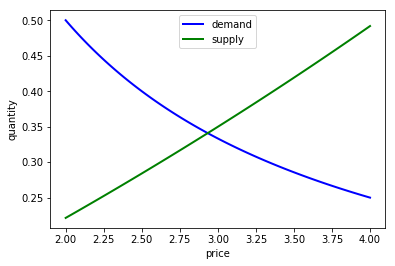

In [13]:
# Now plot
grid = np.linspace(2, 4, 100)
fig, ax = plt.subplots()

supply = np.exp(0.1 * grid) - 1
demand = grid**(-1)


ax.plot(grid, demand, 'b-', lw=2, label='demand')
ax.plot(grid, supply, 'g-', lw=2, label='supply')

ax.set_xlabel('price')
ax.set_ylabel('quantity')
ax.legend(loc='upper center')

plt.show()

We also want to consider supply and demand shifts.

For example, let’s see what happens when demand shifts up, with $ \gamma $ increasing to $ 1.25 $:

In [14]:
# Compute equilibrium
def h(p):
    return 1.25 * p**(-1) - (np.exp(0.1 * p) - 1)

p_star = brentq(h, 2, 4)
q_star = np.exp(0.1 * p_star) - 1

print(f'Equilibrium price is {p_star: .2f}')
print(f'Equilibrium quantity is {q_star: .2f}')

Equilibrium price is  3.25
Equilibrium quantity is  0.38


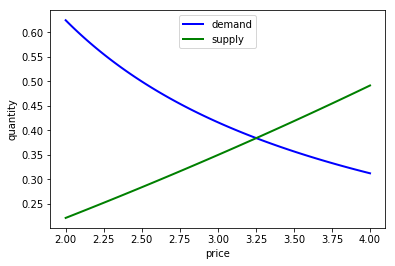

In [16]:
# Now plot
p_grid = np.linspace(2, 4, 100)
fig, ax = plt.subplots()

supply = np.exp(0.1 * p_grid) - 1
demand = 1.25 * p_grid**(-1)


ax.plot(grid, demand, 'b-', lw=2, label='demand')
ax.plot(grid, supply, 'g-', lw=2, label='supply')

ax.set_xlabel('price')
ax.set_ylabel('quantity')
ax.legend(loc='upper center')

plt.show()

Now we might consider supply shifts, but you already get the idea that there’s
a lot of repeated code here.

Refactor and improve clarity in the code above using the principles discussed
in this lecture.

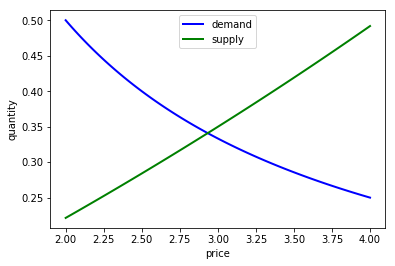

In [39]:
def plot_equ( α, β, γ, δ):
    p_grid = np.linspace(2, 4, 100)
    
  
    supply = np.exp(α * p_grid) - β
    demand = γ * p_grid**(-δ)
    
    ax.plot(grid, demand, 'b-', lw=2, label='demand')
    ax.plot(grid, supply, 'g-', lw=2, label='supply')

    ax.set_xlabel('price')
    ax.set_ylabel('quantity')
    ax.legend(loc='upper center')
    plt.show()

fig, ax = plt.subplots()
gammas=np.array([1, 1.25])
for gamma in gammas:
    plot_equ(0.1, gamma, 1,1)

In [35]:
from scipy.optimize import brentq
class equilibrium:
    
    def __init__(self,α=0.1,β=1,δ=1,γ=1):
        self.α, self.β, self.γ, self.δ=α, β, γ, δ
        
    def demand(self,p):
        
        return self.γ * p**(-self.δ)
    def supply(self,p):
        
        return np.exp(self.α * p) - self.β
        
    def find_equ(self,p):
        def h(p):
            return self.demand(p) - self.supply(p)
        
        p_star = brentq(h, 2, 4)
        q_star = np.exp(0.1 * p_star) - 1
    
    
    def plot(self):
        
        grid = np.linspace(2, 4, 100)
        fig, ax = plt.subplots()
        ax.plot(grid, self.demand(grid), 'b-', lw=2, label='demand')
        ax.plot(grid, self.supply(grid), 'g-', lw=2, label='supply')

        ax.set_xlabel('price')
        ax.set_ylabel('quantity')
        ax.legend(loc='upper center')

        plt.show()

    

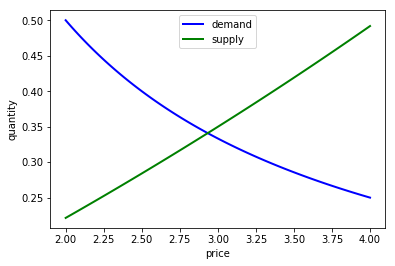

In [36]:
eq=equilibrium()
eq.plot()